##Instalando dependencias 


In [1]:
 !pip install 'fsspec>=0.3.3'

     |████████████████████████████████| 133 kB 5.2 MB/s 


##Imports


In [2]:
import dask.dataframe as dd
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive"

'Colab Notebooks'	 Obra					  'Voluta '
 Curriculo		'trabalho dicertativo de marketing.docx'   Wizard
 ImersaoDev_Alura	'Trem do estagio.gdoc'
'Iniciação Científica'	 UFOP


##Verificando dataset

In [5]:
df = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/IC/eccomerce/database/dataframes/olist_geoleocated_time_prediction.csv')

In [6]:
df = df.compute()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112660 entries, 0 to 112659
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112660 non-null  int64  
 1   order_item_id                  112660 non-null  float64
 2   product_id                     112660 non-null  int64  
 3   seller_id                      112660 non-null  int64  
 4   shipping_limit_date            112660 non-null  object 
 5   price                          112660 non-null  float64
 6   freight_value                  112660 non-null  float64
 7   payment_sequential             112660 non-null  float64
 8   payment_type                   112660 non-null  int64  
 9   payment_installments           112660 non-null  float64
 10  payment_value                  112660 non-null  float64
 11  review_id                      112660 non-null  int64  
 12  review_score                  

In [8]:
df.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,costumer_lat,costumer_lng,seller_lat,seller_lng,days_to_delivery
0,0,1.0,8216,812,2017-09-19 09:45:35,58.9,13.29,1.0,1,2.0,72.19,55789,5.0,56,19620,2017-09-21 00:00:00,2017-09-22 10:57:03,22449,1,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,48076,28013,723,18,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-21.763186,-41.310265,-22.497188,-44.127324,6.0
1,7014,1.0,8216,812,2017-07-05 02:44:11,55.9,17.96,1.0,0,1.0,73.86,65104,5.0,56,29987,2017-07-14 00:00:00,2017-07-17 12:50:07,85025,1,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,5649,75800,1907,8,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-17.884803,-51.717167,-22.497188,-44.127324,6.0
2,30559,1.0,8216,812,2018-05-23 10:56:25,64.9,18.33,1.0,1,2.0,83.23,64310,4.0,4094,28560,2018-06-05 00:00:00,2018-06-06 21:41:12,28995,1,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,18589,30720,443,10,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-19.913964,-43.976106,-22.497188,-44.127324,5.0
3,40954,1.0,8216,812,2017-08-07 18:55:08,58.9,16.17,1.0,1,3.0,75.07,48121,5.0,56,192,2017-08-10 00:00:00,2017-08-13 03:35:17,17783,1,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00,82561,83070,3470,17,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-25.520334,-49.124988,-22.497188,-44.127324,1.0
4,45875,1.0,8216,812,2017-08-16 22:05:11,58.9,13.29,1.0,1,4.0,72.19,24311,5.0,56,192,2017-08-25 00:00:00,2017-08-28 00:51:18,53457,1,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00,4247,36400,1016,10,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-20.655379,-43.776331,-22.497188,-44.127324,1.0
5,58794,1.0,8216,812,2017-08-03 15:23:46,55.9,26.93,1.0,1,1.0,82.83,73293,5.0,56,192,2017-08-27 00:00:00,2017-08-27 12:30:09,26571,1,2017-07-27 15:11:51,2017-07-28 15:23:46,2017-08-02 18:32:34,2017-08-31 20:19:52,2017-08-24 00:00:00,18290,44560,1185,4,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-12.906138,-39.192076,-22.497188,-44.127324,5.0
6,69027,1.0,8216,812,2018-03-26 03:28:44,64.9,38.50,1.0,0,1.0,103.40,66246,5.0,56,13634,2018-03-29 00:00:00,2018-03-30 12:41:53,71997,1,2018-03-18 21:00:44,2018-03-20 03:28:44,2018-03-20 18:08:45,2018-03-28 21:57:44,2018-04-12 00:00:00,17734,45160,442,4,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-15.036469,-41.260324,-22.497188,-44.127324,0.0
7,74190,2.0,8216,812,2017-08-14 04:25:34,58.9,18.12,1.0,0,1.0,153.75,80659,5.0,56,192,2017-08-15 00:00:00,2017-08-24 19:35:04,3718,1,2017-08-05 16:59:05,2017-08-08 04:25:34,2017-08-10 16:40:11,2017-08-14 18:13:03,2017-09-06 00:00:00,47060,75903,3109,8,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-17.782743,-50.917956,-22.497188,-44.127324,2.0
8,74190,1.0,8359,812,2017-08-14 04:25:34,58.9,17.83,1.0,0,1.0,153.75,80659,5.0,56,192,2017-08-15 00:00:00,2017-08-24 19:35:04,3718,1,2017-08-05 16:59:05,2017-08-08 04:25:34,2017-08-10 16:40:11,2017-08-14 18:13:03,2017-09-06 00:00:00,47060,75903,3109,8,27277.0,582,21,26,54.0,599.0,6.0,530.0,30.0,9.0,14.0,-17.782743,-50.917956,-22.497188,-44.127324,2.0
9,82148,1.0,8216,812,2017-06-09 14:31:21,55.9,35.71,2

##Calculando tempo de atraso


In [9]:
#transformando em datas pelo pandas
for col in df[['review_creation_date','order_approved_at','order_delivered_carrier_date','order_estimated_delivery_date','shipping_limit_date','review_answer_timestamp','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date']]:
    df[col] = pd.to_datetime(df[col])

*   Calculando o tempo, em dias, que a entrega foi feita antes da data estimada

*   Para realizar o calculo será feito a subtração do dia estimado para entrega menos o dia em que o pedido foi pedido foi entregue(order_estimated_delivery_date - order_delivered_carrier_date) 


In [10]:
#funcao que calcula o tempo de adiantamento da entrega 
def early_delivery(data):
    # verifica se a entrega foi no mesmo mes 
    if data['order_estimated_delivery_date'].month == data['order_delivered_carrier_date'].month:
        if data['order_estimated_delivery_date'].day < data['order_delivered_carrier_date'].day:
            return 0 #se o dia da entrega é depois do dia estimado, nao teve adiantamento 
        else:
            return data['order_estimated_delivery_date'].day - data['order_delivered_carrier_date'].day
    
    # se ocorreu em meses diferentes, calcula-se os dias para cada mes e depois soma
    elif data['order_estimated_delivery_date'].month != data['order_delivered_carrier_date'].month:
          if data['order_estimated_delivery_date'].month < data['order_delivered_carrier_date'].month:
            return 0
          else:
            return (pd.Period(data['order_delivered_carrier_date'], freq='D').days_in_month - data['order_delivered_carrier_date'].day) + data['order_estimated_delivery_date'].day

    
df['early_delivery'] = df.apply(early_delivery, axis=1)

In [11]:
df.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,costumer_lat,costumer_lng,seller_lat,seller_lng,days_to_delivery,early_delivery
0,0,1.0,8216,812,2017-09-19 09:45:35,58.9,13.29,1.0,1,2.0,72.19,55789,5.0,56,19620,2017-09-21,2017-09-22 10:57:03,22449,1,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,48076,28013,723,18,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-21.763186,-41.310265,-22.497188,-44.127324,6.0,10
1,7014,1.0,8216,812,2017-07-05 02:44:11,55.9,17.96,1.0,0,1.0,73.86,65104,5.0,56,29987,2017-07-14,2017-07-17 12:50:07,85025,1,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,5649,75800,1907,8,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-17.884803,-51.717167,-22.497188,-44.127324,6.0,21
2,30559,1.0,8216,812,2018-05-23 10:56:25,64.9,18.33,1.0,1,2.0,83.23,64310,4.0,4094,28560,2018-06-05,2018-06-06 21:41:12,28995,1,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,18589,30720,443,10,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-19.913964,-43.976106,-22.497188,-44.127324,5.0,15
3,40954,1.0,8216,812,2017-08-07 18:55:08,58.9,16.17,1.0,1,3.0,75.07,48121,5.0,56,192,2017-08-10,2017-08-13 03:35:17,17783,1,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,82561,83070,3470,17,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-25.520334,-49.124988,-22.497188,-44.127324,1.0,23
4,45875,1.0,8216,812,2017-08-16 22:05:11,58.9,13.29,1.0,1,4.0,72.19,24311,5.0,56,192,2017-08-25,2017-08-28 00:51:18,53457,1,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,4247,36400,1016,10,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-20.655379,-43.776331,-22.497188,-44.127324,1.0,21
5,58794,1.0,8216,812,2017-08-03 15:23:46,55.9,26.93,1.0,1,1.0,82.83,73293,5.0,56,192,2017-08-27,2017-08-27 12:30:09,26571,1,2017-07-27 15:11:51,2017-07-28 15:23:46,2017-08-02 18:32:34,2017-08-31 20:19:52,2017-08-24,18290,44560,1185,4,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-12.906138,-39.192076,-22.497188,-44.127324,5.0,22
6,69027,1.0,8216,812,2018-03-26 03:28:44,64.9,38.50,1.0,0,1.0,103.40,66246,5.0,56,13634,2018-03-29,2018-03-30 12:41:53,71997,1,2018-03-18 21:00:44,2018-03-20 03:28:44,2018-03-20 18:08:45,2018-03-28 21:57:44,2018-04-12,17734,45160,442,4,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-15.036469,-41.260324,-22.497188,-44.127324,0.0,23
7,74190,2.0,8216,812,2017-08-14 04:25:34,58.9,18.12,1.0,0,1.0,153.75,80659,5.0,56,192,2017-08-15,2017-08-24 19:35:04,3718,1,2017-08-05 16:59:05,2017-08-08 04:25:34,2017-08-10 16:40:11,2017-08-14 18:13:03,2017-09-06,47060,75903,3109,8,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-17.782743,-50.917956,-22.497188,-44.127324,2.0,27
8,74190,1.0,8359,812,2017-08-14 04:25:34,58.9,17.83,1.0,0,1.0,153.75,80659,5.0,56,192,2017-08-15,2017-08-24 19:35:04,3718,1,2017-08-05 16:59:05,2017-08-08 04:25:34,2017-08-10 16:40:11,2017-08-14 18:13:03,2017-09-06,47060,75903,3109,8,27277.0,582,21,26,54.0,599.0,6.0,530.0,30.0,9.0,14.0,-17.782743,-50.917956,-22.497188,-44.127324,2.0,27
9,82148,1.0,8216,812,2017-06-09 14:31:21,55.9,35.71,2.0,3,1.0,20.00,28668,1.0,56,30742,2017-06-27,2017-06-30 14:26:54,17106,1,2017-06-05 12:22:19,2017-06-05 14:31:21,2017-06

##Separando datas em novas colunas



In [12]:
#separando dia
def day_shipping(data):
    return data['shipping_limit_date'].day

df["day_shipping"] = df.apply(day_shipping, axis = 1)

#separando mes
def month_shipping(data):
    return data['shipping_limit_date'].month

df["month_shipping"] = df.apply(month_shipping, axis = 1)

#separando ano
def year_shipping(data):
    return data['shipping_limit_date'].year

df["year_shipping"] = df.apply(year_shipping, axis = 1)

In [13]:
#separando dia
def day_review_creation(data):
    return data['review_creation_date'].day

df["day_review_creation"] = df.apply(day_review_creation, axis = 1)

#separando mes
def month_review_creation(data):
    return data['review_creation_date'].month

df["month_review_creation"] = df.apply(month_review_creation, axis = 1)

#separando ano
def year_review_creation(data):
    return data['review_creation_date'].year

df["year_review_creation"] = df.apply(year_review_creation, axis = 1)

In [14]:
#separando dia
def day_review_answer(data):
    return data['review_answer_timestamp'].day

df["day_review_answer"] = df.apply(day_review_answer, axis = 1)

#separando mes
def month_review_answer(data):
    return data['review_answer_timestamp'].month

df["month_review_answer"] = df.apply(month_review_answer, axis = 1)

#separando ano
def year_review_answer(data):
    return data['review_answer_timestamp'].year

df["year_review_answer"] = df.apply(year_review_answer, axis = 1)

In [15]:
#separando dia
def day_order_purchase_timestamp(data):
    return data['order_purchase_timestamp'].day

df["day_order_purchase_timestamp"] = df.apply(day_order_purchase_timestamp, axis = 1)

#separando mes
def month_order_purchase_timestamp(data):
    return data['order_purchase_timestamp'].month

df["month_order_purchase_timestamp"] = df.apply(month_order_purchase_timestamp, axis = 1)

#separando ano
def year_order_purchase_timestamp(data):
    return data['order_purchase_timestamp'].year

df["year_order_purchase_timestamp"] = df.apply(year_order_purchase_timestamp, axis = 1)

In [16]:
#separando dia
def day_order_approved(data):
    return data['order_approved_at'].day

df["day_order_approved"] = df.apply(day_order_approved, axis = 1)

#separando mes
def month_order_approved(data):
    return data['order_approved_at'].month

df["month_order_approved"] = df.apply(month_order_approved, axis = 1)

#separando ano
def year_order_approved(data):
    return data['order_approved_at'].year

df["year_order_approved"] = df.apply(year_order_approved, axis = 1)

In [17]:
#separando dia
def day_order_delivered_carrier(data):
    return data['order_delivered_carrier_date'].day

df["day_order_delivered_carrier"] = df.apply(day_order_delivered_carrier, axis = 1)

#separando mes
def month_order_delivered_carrier(data):
    return data['order_delivered_carrier_date'].month

df["month_order_delivered_carrier"] = df.apply(month_order_delivered_carrier, axis = 1)

#separando ano
def year_order_delivered_carrier(data):
    return data['order_delivered_carrier_date'].year

df["year_order_delivered_carrier"] = df.apply(year_order_delivered_carrier, axis = 1)


In [18]:
#separando dia
def day_order_delivered_customer(data):
    return data['order_delivered_customer_date'].day

df["day_order_delivered_customer"] = df.apply(day_order_delivered_customer, axis = 1)

#separando mes
def month_order_delivered_customer(data):
    return data['order_delivered_customer_date'].month

df["month_order_delivered_customer"] = df.apply(month_order_delivered_customer, axis = 1)

#separando ano
def year_order_delivered_customer(data):
    return data['order_delivered_customer_date'].year

df["year_order_delivered_customerr"] = df.apply(year_order_delivered_customer, axis = 1)

In [19]:
#separando dia
def day_estimated_delivery(data):
    return data['order_estimated_delivery_date'].day

df["day_estimated_delivery"] = df.apply(day_estimated_delivery, axis = 1)

#separando mes
def month_estimated_delivery(data):
    return data['order_estimated_delivery_date'].month

df["month_estimated_delivery"] = df.apply(month_estimated_delivery, axis = 1)

#separando ano
def year_estimated_delivery(data):
    return data['order_estimated_delivery_date'].year

df["year_estimated_delivery"] = df.apply(year_estimated_delivery, axis = 1)


In [20]:
df.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,costumer_lat,costumer_lng,seller_lat,seller_lng,days_to_delivery,early_delivery,day_shipping,month_shipping,year_shipping,day_review_creation,month_review_creation,year_review_creation,day_review_answer,month_review_answer,year_review_answer,day_order_purchase_timestamp,month_order_purchase_timestamp,year_order_purchase_timestamp,day_order_approved,month_order_approved,year_order_approved,day_order_delivered_carrier,month_order_delivered_carrier,year_order_delivered_carrier,day_order_delivered_customer,month_order_delivered_customer,year_order_delivered_customerr,day_estimated_delivery,month_estimated_delivery,year_estimated_delivery
0,0,1.0,8216,812,2017-09-19 09:45:35,58.9,13.29,1.0,1,2.0,72.19,55789,5.0,56,19620,2017-09-21,2017-09-22 10:57:03,22449,1,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,48076,28013,723,18,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-21.763186,-41.310265,-22.497188,-44.127324,6.0,10,19,9,2017,21,9,2017,22,9,2017,13,9,2017,13,9,2017,19,9,2017,20,9,2017,29,9,2017
1,7014,1.0,8216,812,2017-07-05 02:44:11,55.9,17.96,1.0,0,1.0,73.86,65104,5.0,56,29987,2017-07-14,2017-07-17 12:50:07,85025,1,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,5649,75800,1907,8,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-17.884803,-51.717167,-22.497188,-44.127324,6.0,21,5,7,2017,14,7,2017,17,7,2017,28,6,2017,29,6,2017,5,7,2017,13,7,2017,26,7,2017
2,30559,1.0,8216,812,2018-05-23 10:56:25,64.9,18.33,1.0,1,2.0,83.23,64310,4.0,4094,28560,2018-06-05,2018-06-06 21:41:12,28995,1,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,18589,30720,443,10,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-19.913964,-43.976106,-22.497188,-44.127324,5.0,15,23,5,2018,5,6,2018,6,6,2018,18,5,2018,18,5,2018,23,5,2018,4,6,2018,7,6,2018
3,40954,1.0,8216,812,2017-08-07 18:55:08,58.9,16.17,1.0,1,3.0,75.07,48121,5.0,56,192,2017-08-10,2017-08-13 03:35:17,17783,1,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,82561,83070,3470,17,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-25.520334,-49.124988,-22.497188,-44.127324,1.0,23,7,8,2017,10,8,2017,13,8,2017,1,8,2017,1,8,2017,2,8,2017,9,8,2017,25,8,2017
4,45875,1.0,8216,812,2017-08-16 22:05:11,58.9,13.29,1.0,1,4.0,72.19,24311,5.0,56,192,2017-08-25,2017-08-28 00:51:18,53457,1,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,4247,36400,1016,10,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-20.655379,-43.776331,-22.497188,-44.127324,1.0,21,16,8,2017,25,8,2017,28,8,2017,10,8,2017,10,8,2017,11,8,2017,24,8,2017,1,9,2017
5,58794,1.0,8216,812,2017-08-03 15:23:46,55.9,26.93,1.0,1,1.0,82.83,73293,5.0,56,192,2017-08-27,2017-08-27 12:30:09,26571,1,2017-07-27 15:11:51,2017-07-28 15:23:46,2017-08-02 18:32:34,2017-08-31 20:19:52,2017-08-24,18290,44560,1185,4,27277.0,582,21,26,58.0,598.0,4.0,650.0,28.0,9.0,14.0,-12.906138,-39.192076,-22.497188,-44.127324,5.0,22,3,8,2017,27,8,2017,27,8,2017,27,7,2017,28,7,2017,2,8,2017,31,8,2017,24,8,2017
6,69027,1.0,8216,812,2018-03-26 03:28:44,64.9,38.50,1.0,0,1.0,103.40,66246,5.0,56,13634,2018-03-29,2018-03-30 12:41:53,71997,1,2018-03-18 21:00:44,2018-03-20 03:

##Preparando os dados para testar os modelos


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112660 entries, 0 to 112659
Data columns (total 69 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   order_id                        112660 non-null  int64         
 1   order_item_id                   112660 non-null  float64       
 2   product_id                      112660 non-null  int64         
 3   seller_id                       112660 non-null  int64         
 4   shipping_limit_date             112660 non-null  datetime64[ns]
 5   price                           112660 non-null  float64       
 6   freight_value                   112660 non-null  float64       
 7   payment_sequential              112660 non-null  float64       
 8   payment_type                    112660 non-null  int64         
 9   payment_installments            112660 non-null  float64       
 10  payment_value                   112660 non-null  float64

In [22]:
df.isnull().sum()

order_id                          0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
                                 ..
month_order_delivered_customer    0
year_order_delivered_customerr    0
day_estimated_delivery            0
month_estimated_delivery          0
year_estimated_delivery           0
Length: 69, dtype: int64

In [23]:
#retirando valores nulos ou duplicados
df.dropna(inplace=True)

In [24]:
#excluindo as colunas que estão em formato pandas df, pois já são representadas nas colunas separadas 
df = df.drop(['shipping_limit_date','review_creation_date','review_answer_timestamp','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111237 entries, 0 to 112659
Data columns (total 61 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        111237 non-null  int64  
 1   order_item_id                   111237 non-null  float64
 2   product_id                      111237 non-null  int64  
 3   seller_id                       111237 non-null  int64  
 4   price                           111237 non-null  float64
 5   freight_value                   111237 non-null  float64
 6   payment_sequential              111237 non-null  float64
 7   payment_type                    111237 non-null  int64  
 8   payment_installments            111237 non-null  float64
 9   payment_value                   111237 non-null  float64
 10  review_id                       111237 non-null  int64  
 11  review_score                    111237 non-null  float64
 12  review_comment_t

payments_sequential

In [26]:
df = df.astype(float)

In [27]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
import matplotlib.pyplot as plt

(array([4.9874e+04, 1.9438e+04, 1.3965e+04, 8.8610e+03, 5.8930e+03,
        4.3120e+03, 2.4120e+03, 1.3040e+03, 8.9300e+02, 7.5700e+02,
        1.0520e+03, 4.5200e+02, 4.4900e+02, 2.7900e+02, 1.6800e+02,
        1.9200e+02, 1.4100e+02, 1.0900e+02, 1.4700e+02, 9.6000e+01,
        1.1500e+02, 5.7000e+01, 4.1000e+01, 2.6000e+01, 3.0000e+01,
        1.9000e+01, 1.7000e+01, 1.6000e+01, 7.0000e+00, 9.0000e+00,
        2.8000e+01, 1.7000e+01, 1.0000e+01, 4.0000e+00, 3.0000e+00,
        5.0000e+00, 5.0000e+00, 7.0000e+00, 3.0000e+00, 5.0000e+00,
        1.4000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ,
        12.1, 13.2, 14.3, 15.4, 16.5, 17.6, 18.7, 19.8, 20.9, 22. , 23.1,
        24.2, 25.3, 26.4, 27.5, 28.6, 29.7, 30.8, 31.9, 33. , 34.1, 35.2,
        36.3, 37.4, 38.5, 39.6, 40.7, 41.8, 42.9, 44. , 45.1, 46.2, 47.3,
        48.4, 49.5, 50

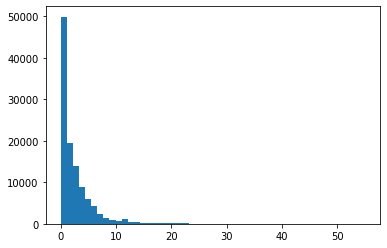

In [ ]:
plt.hist(df.days_to_delivery, 50)

##Days to delivery

In [ ]:
colunas = ['Modelo','Fine-Tuning','MAE','MAPE'] 
MetricsDaysToDelivery = pd.DataFrame(columns = colunas)

In [ ]:
##separando as variaveis dependente e independente em dois data frames
X = df.drop(['days_to_delivery'], 1)
Y = df['days_to_delivery']

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=150)

###Modelos


####Linear Regression

In [ ]:
model = LinearRegression()

my_pipeline = Pipeline(steps=[('m', model)])


#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'LinearRegression',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysToDelivery = MetricsDaysToDelivery.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysToDelivery

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,0.120709,5.036595e+13


####Decision Tree


In [ ]:
model = DecisionTreeRegressor(random_state=150)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'Decision Tree',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysToDelivery = MetricsDaysToDelivery.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysToDelivery

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,0.120709,5.036595e+13
1,Decision Tree,Nao,1.265613,7.817135e+14


####Random forest trees

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'Random Forest',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysToDelivery = MetricsDaysToDelivery.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysToDelivery

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,0.120709,5.036595e+13
1,Decision Tree,Nao,1.265613,7.817135e+14
2,Random Forest,Nao,1.563092,1.403056e+15


####XGBoost

In [ ]:
model = xgb.XGBRegressor(silent = True)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'XGB',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysToDelivery = MetricsDaysToDelivery.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysToDelivery

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,0.120709,5.036595e+13
1,Decision Tree,Nao,1.265613,7.817135e+14
2,Random Forest,Nao,1.563092,1.403056e+15
3,XGB,Nao,1.125542,1.077378e+15


###Fine Turing

####Linear Regression

####Decision Tree

####Random Forest 

####XGBoost

In [ ]:
xgbr = xgb.XGBRegressor(silent=True)

parameters = {'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7], 
              'min_child_weight': [1, 2, 3,4], 
              'subsample': [1, 0.7], 
              'colsample_bytree': [1, 0.7]} 

xgb_grid = GridSearchCV(xgbr,
                        parameters,
                        cv = kf,
                        verbose=True)

xgb_grid.fit(X,Y)

print(xgb_grid.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
model = xgb.XGBRegressor(silent = True, colsample_bytree= 0.7, learning_rate= 0.07, max_depth= 6, min_child_weight= 4, subsample= 0.7)

my_pipeline = Pipeline(steps=[('m', model)])

scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'XGB',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysToDelivery = MetricsDaysToDelivery.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysToDelivery

##Days delivery in advance 



In [ ]:
MetricsDaysDeliveryInAdvance = pd.DataFrame(columns = colunas)

In [ ]:
##separando as variaveis dependente e independente em dois data frames
X = df.drop(['early_delivery'], 1)
Y = df['early_delivery']

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=150)

###Modelos

####Linear Regression

In [ ]:
model = LinearRegression()

my_pipeline = Pipeline(steps=[('m', model)])


#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'LinearRegression',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,2.402021,7.970890e+14


####Decision Tree

In [ ]:
model = DecisionTreeRegressor(random_state=150)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'Decision Tree',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,2.402021,7.970890e+14
1,Decision Tree,Nao,1.301178,7.757219e+13


####Random Forest 

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'Random Forest',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

####XGBoost

In [ ]:
model = xgb.XGBRegressor(silent = True)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'XGB',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,2.402021,7.970890e+14
1,Decision Tree,Nao,1.301178,7.757219e+13
2,Random Forest,Nao,1.445416,1.035690e+14
3,XGB,Nao,3.101517,4.524648e+14


###Fine Tuning

In [ ]:
model = LinearRegression()

my_pipeline = Pipeline(steps=[('m', model)])


#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'LinearRegression',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,2.402021,7.970890e+14


####Decision Tree

In [ ]:
model = DecisionTreeRegressor(random_state=150)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'Decision Tree',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

,Modelo,Fine-Tuning,MAE,MAPE
0,LinearRegression,Nao,2.402021,7.970890e+14
1,Decision Tree,Nao,1.301178,7.757219e+13


####Random Forest 

In [ ]:
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=0)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'Random Forest',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

####XGBoost

In [ ]:
model = xgb.XGBRegressor(silent = True)

my_pipeline = Pipeline(steps=[('m', model)])

#Define as metricas que quer utilizar.
scoring = {'mae' :'neg_mean_absolute_error',
           'mape': 'neg_mean_absolute_percentage_error'}

scores = cross_validate(my_pipeline, 
                        X, Y,
                        cv=kf,
                        scoring=scoring)

# Criar um dicionario com os resultados 
resultado = {'Modelo'     : 'XGB',
             'Fine-Tuning': 'Nao',
             'MAE'        : -1*np.mean(scores['test_mae']),
             'MAPE'       : -1*np.mean(scores['test_mape'])}

MetricsDaysDeliveryInAdvance = MetricsDaysDeliveryInAdvance.append(resultado,ignore_index=True)

In [ ]:
MetricsDaysDeliveryInAdvance

#Removendo colunas 

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111237 entries, 0 to 112659
Data columns (total 61 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        111237 non-null  float64
 1   order_item_id                   111237 non-null  float64
 2   product_id                      111237 non-null  float64
 3   seller_id                       111237 non-null  float64
 4   price                           111237 non-null  float64
 5   freight_value                   111237 non-null  float64
 6   payment_sequential              111237 non-null  float64
 7   payment_type                    111237 non-null  float64
 8   payment_installments            111237 non-null  float64
 9   payment_value                   111237 non-null  float64
 10  review_id                       111237 non-null  float64
 11  review_score                    111237 non-null  float64
 12  review_comment_t

In [30]:
df = df.drop(['year_estimated_delivery','month_estimated_delivery','day_estimated_delivery','year_order_delivered_customerr','month_order_delivered_customer','day_order_delivered_customer','year_order_delivered_carrier','month_order_delivered_carrier','day_order_delivered_carrier','year_order_purchase_timestamp','month_order_purchase_timestamp','day_order_purchase_timestamp'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111237 entries, 0 to 112659
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    111237 non-null  float64
 1   order_item_id               111237 non-null  float64
 2   product_id                  111237 non-null  float64
 3   seller_id                   111237 non-null  float64
 4   price                       111237 non-null  float64
 5   freight_value               111237 non-null  float64
 6   payment_sequential          111237 non-null  float64
 7   payment_type                111237 non-null  float64
 8   payment_installments        111237 non-null  float64
 9   payment_value               111237 non-null  float64
 10  review_id                   111237 non-null  float64
 11  review_score                111237 non-null  float64
 12  review_comment_title        111237 non-null  float64
 13  review_comment

In [33]:
df = df.drop(['year_review_answer','month_review_answer','day_review_answer','year_review_creation','month_review_creation','day_review_creation',], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111237 entries, 0 to 112659
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    111237 non-null  float64
 1   order_item_id               111237 non-null  float64
 2   product_id                  111237 non-null  float64
 3   seller_id                   111237 non-null  float64
 4   price                       111237 non-null  float64
 5   freight_value               111237 non-null  float64
 6   payment_sequential          111237 non-null  float64
 7   payment_type                111237 non-null  float64
 8   payment_installments        111237 non-null  float64
 9   payment_value               111237 non-null  float64
 10  review_id                   111237 non-null  float64
 11  review_score                111237 non-null  float64
 12  review_comment_title        111237 non-null  float64
 13  review_comment

In [35]:
df = df.drop(['payment_sequential','review_id','review_score','review_comment_title','review_comment_message','order_status','customer_id','customer_zip_code_prefix','customer_city','customer_state','seller_zip_code_prefix','seller_city','seller_state','product_name_lenght','product_description_lenght','product_photos_qty'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111237 entries, 0 to 112659
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               111237 non-null  float64
 1   order_item_id          111237 non-null  float64
 2   product_id             111237 non-null  float64
 3   seller_id              111237 non-null  float64
 4   price                  111237 non-null  float64
 5   freight_value          111237 non-null  float64
 6   payment_type           111237 non-null  float64
 7   payment_installments   111237 non-null  float64
 8   payment_value          111237 non-null  float64
 9   customer_unique_id     111237 non-null  float64
 10  product_category_name  111237 non-null  float64
 11  product_weight_g       111237 non-null  float64
 12  product_length_cm      111237 non-null  float64
 13  product_height_cm      111237 non-null  float64
 14  product_width_cm       111237 non-nu

In [37]:
from google.colab import files
df.to_csv('olist_new_df.csv',index=False) 
files.download('olist_new_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>